<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_2Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

## [MY CODE] 환경 확인용

In [ ]:
import torch

print(torch.__version__)
print(torch.version.cuda)  # PyTorch에서 사용하는 CUDA 버전
print(torch.cuda.is_available())  # GPU 사용 가능 여부


2.5.1+cu121
12.1
True


In [ ]:
!pip install datasets sacremoses

## [MY CODE] labels.append(row['label'])  텍스트의 실제 클래스 레이블을 사용 안하니깐 -값이 나타나서 학습이 되질 않았음


In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')




def collate_fn(batch):
    max_len = 400  # 최대 시퀀스 길이
    texts, labels = [], []

    for row in batch:
        # 텍스트에 대한 토큰화 및 패딩
        encoding = tokenizer(row['text'], truncation=True, max_length=max_len, padding='max_length')
        texts.append(torch.LongTensor(encoding['input_ids']))  # 패딩된 input_ids
        labels.append(row['label'])  # 텍스트의 실제 클래스 레이블을 사용

    # 텍스트 배치 생성
    texts = torch.stack(texts, dim=0)  # batch_size x max_len

    # 레이블은 단순히 텍스트의 클래스 레이블
    labels = torch.LongTensor(labels)  # batch_size 크기의 레이블

    return texts, labels

# 데이터 로더 정의
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Multi-head attention(MHA) 구현

## [MY CODE]
  - Multi를 위한 n_heads 추가
  - D가 H로 나눠 떨어지는 값이여야 하는 제약 조건

In [ ]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        assert d_model % n_heads == 0, "d_model은 n_heads로 나누어 떨어져야 합니다."

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # 1. Query, Key, Value 생성
        q = self.wq(x)  # (B, S, D)
        k = self.wk(x)  # (B, S, D)
        v = self.wv(x)  # (B, S, D)

        # 2. Reshape: (B, S, D) -> (B, S, H, D')
        q = q.view(batch_size, seq_len, self.n_heads, self.d_head)
        k = k.view(batch_size, seq_len, self.n_heads, self.d_head)
        v = v.view(batch_size, seq_len, self.n_heads, self.d_head)

        # 3. Transpose: (B, S, H, D') -> (B, H, S, D')
        q = q.transpose(1, 2)  # (B, H, S, D')
        k = k.transpose(1, 2)  # (B, H, S, D')
        v = v.transpose(1, 2)  # (B, H, S, D')

        # 4. Scaled Dot-Product Attention 계산
        score = torch.matmul(q, k.transpose(-2, -1)) / sqrt(self.d_head)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, 1, S)
            score = score.masked_fill(mask == 0, -1e9)

        attention = torch.matmul(self.softmax(score), v)

        # 5. Transpose 및 Reshape: (B, H, S, D') -> (B, S, D)
        attention = attention.transpose(1, 2).contiguous()
        attention = attention.view(batch_size, seq_len, self.d_model)

        # 6. Output
        output = self.dense(attention)

        return output

## Transformer 레이어 수정

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, dff, n_heads, dropout_rate=0.1):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff
        self.n_heads = n_heads

        # Multi-Head Attention 모듈
        self.mha = MultiHeadAttention(input_dim, d_model, n_heads)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        # Dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer Normalization
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # x, mask is given
        # Multi-Head Attention
        x1 = self.mha(x, mask)
        x1 = self.dropout1(x1)
        x1 = self.ln1(x1 + x)

        # Feed Forward Network
        x2 = self.ffn(x1)
        x2 = self.dropout2(x2)
        x2 = self.ln2(x2 + x1)

        return x2


보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [ ]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [ ]:
from math import sqrt

# 모델 정의
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        # 임베딩 및 포지셔널 인코딩
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(
            positional_encoding(512, d_model), requires_grad=False
        )

        # Transformer 레이어
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads=4) for _ in range(n_layers)])


        # 분류를 위한 최종 선형 레이어 (이진 분류로 1로 설정)
        self.classification = nn.Linear(d_model, 1)  # 이진 분류이므로 출력 차원 1로 설정

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)  # 스케일링(scaling) 추가
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]  # [batch_size, d_model] 형태로 첫 번째 token만 추출
        x = self.classification(x)  # 출력 차원 1로

        # 이진 분류에서는 sigmoid를 사용하여 확률 값으로 변환
        x = torch.sigmoid(x)

        return x

# 모델 정의
model = TextClassifier(len(tokenizer), 32, 2, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [ ]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss() # 손실 함수 정의

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

## [MY CODE] RuntimeError Traceback (most recent call last)                          
  -  마지막 차원을 제거하여 크기 일치

In [ ]:
train_accs, test_accs = [], []  # 학습 정확도 리스트 # 테스트 정확도 리스트

n_epochs = 50

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
        model.eval()

        # 훈련 데이터와 테스트 데이터에 대한 정확도 계산
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)

        # 정확도를 리스트에 추가
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # 각 에포크마다 출력
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 270.8420925140381
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   1 | Train Loss: 265.44467729330063
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   2 | Train Loss: 262.6691266298294
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   3 | Train Loss: 261.1559073328972
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   4 | Train Loss: 260.2945771217346
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   5 | Train Loss: 259.56401228904724
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   6 | Train Loss: 259.20717817544937
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   7 | Train Loss: 258.689484000206
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   8 | Train Loss: 258.4937250614166
=========> Train acc: 0.500 | Test acc: 0.500
Epoch   9 | Train Loss: 258.0324929356575
=========> Train acc: 0.500 | Test acc: 0.500
Epoch  10 | Train Loss: 257.9855861067772
=========> Train acc: 0.500 | Test acc: 0.500
Epoch  11 | Train Loss: 257.76

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.
하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

## [LOG] 결과 출력

## 5-layer 4-head Transformer
    - 기존 실습에서 사용한 hyper-parameter들과 위에서 구현한 Transformer를 가지고 5-layer 4-head Transformer의 성능 결과를 report해주시면 됩니다.

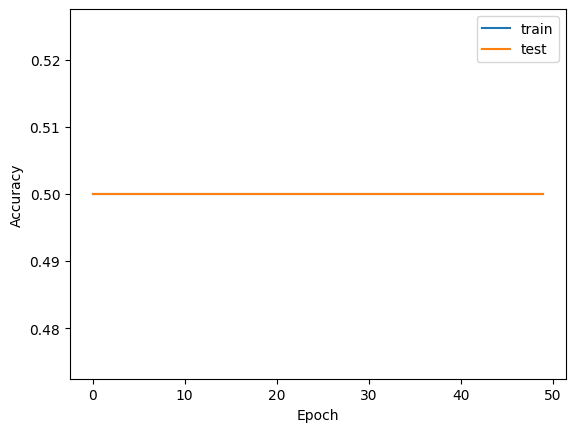

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_acc, test_acc, label1='train', label2='test'):
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label=label1)
    plt.plot(x, test_acc, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습이 끝난 후, train_accs와 test_accs를 plot_acc 함수에 전달
plot_acc(train_accs, test_accs)